In [15]:
#!pip install summarytools

In [16]:
# Import libraries

import numpy as np
import pandas as pd
from summarytools import dfSummary
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# Load data and read first 5 rows

df = pd.read_csv("/content/drive/MyDrive/marketing_data.csv")

df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [18]:
# Generate a detailed report of our dataset

dfSummary(df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,ID[int64],Mean (sd) : 5592.2 (3246.7)min < med < max:0.0 < 5458.5 < 11191.0IQR (CV) : 5599.5 (1.7),"2,240 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACq0lEQVR4nO3bTU4iQRiH8bcGP0ow3eEjsOMCJrMgccMBZjmHnSO4cDFrbsDOxBAIjISmYVbuROkqS/qPz2+LJaTzWP1WE91+vzeg7n6c+gMAx7g49QfA+XDO3ZjZVeDyzX6/fzn0IqHiUzjnbrrd7u8sy9oh6xeLxcw59+dQrISKz3KVZVl7PB6/5Hm+rrJwPp/7x8fH9vPz85WZESrSy/N83e/3/wUsvXnvRUI9IOW8heoI9Q2p5y1Ud7ahRu6I2e3tbX88Hi9SzFuortahRsTmO53OrzzPWyHvWxSFL8vy7vr6+iHFvIXqahtqzO23KApvZnf39/d/e73eour66XTankwmze1226i6Fml8GOoJDxXBjzteQ/PeFyE74mw2i9oRy7K8NLPMOReynIPYG94NtQ6HipDHHbGhxVitVpdFUfwcDoeNRqNR6Q/MjIPYIR/tqEkf4p6jzWZz4b1vjkaj9WAwmFVZ+12v2TGOmlFDH+KWZZlZ+C0w2+12lyEL66DVap3impmd6eiQ7DAVewt8PXmv1+sHMws5ecuJvWZmcaND7CO9lBtLslBjboFm3/PkHXvNYkaH2PNI6o0l+eOp0FvgKQ9EpxZ6zcyiRofgLznM0m8stX2OiupiRofYLzlSbyyEekZiRoe6j1qEeoZCRoe6j1r8zxQkECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokXBzzQ/P53Ff9xcvl0puZrVYr//T01PzK9arvrfq5Y9cf09d/5I6UrA562QkAAAAASUVORK5CYII="">",0(0.0%)
2,Year_Birth[int64],Mean (sd) : 1968.8 (12.0)min < med < max:1893.0 < 1970.0 < 1996.0IQR (CV) : 18.0 (164.3),59 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACcUlEQVR4nO3cMY7aQBSA4TdhITYgWwgFOi4QiYKSQ+SwOUIKTkBLRWeBkBHOOhjjdJEiJcvaM17mWf9XM8sUf7HG88ZUVSWA7z49ewPAe7w8ewNwyxgTisig4fJrVVWvLvfjCqF2iDEmnE6n36IomjRZfz6fT8aY7z7GSqjdMoiiaLJer1/jOM7rLEzTNNhsNpPj8TgQEUJF++I4zmez2c8GS0Pnm3GEhymoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFXqJ6xPP0U3e/3vsv9+IJQPWJ7+qkoiqAsy695nv8QkSbv+r1FqH5pfPpJRGS/30+22+3wdrv12tjcMxGqh5qefjqdTt6efrJFqPijLMu+iETGmKZ/orUJAUKFiIhkWdYvimK5WCx6vV6v9r8dIu1OCBAqRETker2+BEEwXK1W+Xw+P9Vd3/aEAKHiL6PRqOl0gEiLEwL84A8VCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQocnG6BxWx+Z+fybRGqYzaz+V2ey7dFqO41ns3v8ly+LUJtSZPZ/C7P5dviYQoqECpUIFSoQKhQgVChAqFCBUKFCvyOCmcsr61888pKQoUTttdWPrqyklDhhM21le+5spJQ4ZTFtZVvvj7mYQoqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFDKf/BtTx+IdR/4Foe/zwM1RgTiMjnD9iLT6LxePxluVzewjD8VWfh4XAIdrvdME3TUZIk1zprL5dLICKSZVmQJMmwzlrb9c/87jRNg0ef+Q2XKfNdF6QuEQAAAABJRU5ErkJggg=="">",0(0.0%)
3,Education[object],1. Graduation2. PhD3. Master4. 2n Cycle5. Basic,"1,127 (50.3%)486 (21.7%)370 (16.5%)203 (9.1%)54 (2.4%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABzCAYAAACPdnBjAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACRUlEQVR4nO3bMWrjUBiF0V+DCZNGwhi8GC9iFjuL0G6MsYokpNEUU4WkiBV0JdnnbCCP8CHxjG4zjmNBwq+lD8DjEBsxYiOmqarnqnpa+iAb9D6O4+vSh9iS3eFw+NO27X7pg2zNMAyXpmn+Cu77dm3b7k+n02vXdW9LH2Yrrtfr777v9+fz+amqxPZNu6qqruvejsfjy9KH2ZjnpQ+wNS4IxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEbMrur/JzNLH2RL/L+m2Q3DcOn7fl8+mbnJMAyXqnpf+hxb4rPw6XwWfqPGbpQUFwRi1vQa9Vq6c6tZV1kr3b9VrKuslR7DmtZVfnq5cy4IxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEbMKtZVS/99MlazrrJWun8+CyfGuooYFwRikq9Rr8kHF1tXWU8RWVdZT1GVXVdZTz04FwRixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiIyayrrKeoiq4rrKewmfhxFhXEfOTJ5snFTeZPHgxYOFWkwYvBixM8ZPBiwELN/GjLjFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZiJq2rrKWYYvK6ylqKW9kgEGNdRcxXTzZPLGbxaV1lNcVcPqyrrKaY01frKqspZuFHXWLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEfFhXWU0xp0/rKqsp5mKDQIx1FTEuCMSIjZh/O3UON/LmBqQAAAAASUVORK5CYII="">",0(0.0%)
4,Marital_Status[object],1. Married2. Together3. Single4. Divorced5. Widow6. Alone7. Absurd8. YOLO,864 (38.6%)580 (25.9%)480 (21.4%)232 (10.4%)77 (3.4%)3 (0.1%)2 (0.1%)2 (0.1%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAC4CAYAAAD0WZ4UAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZl

**Observations**
1. 2,240 customers with 29 attributes.
2. Our dataset has 24 null values in the ' Income ' column but no duplicates.
3. The dataset has attributes describing the customers, their purchases and their respective responses to various campaigns.
4. Some columns need cleaning; changing datatypes
5. 'ID', 'Z_CostContact' and 'Z_Revenue' do not add much information to our analysis.


### **Cleaning**

---



In [27]:
# Drop rows with missing values
df = df.dropna()
print(df.shape)

# Change to appropriate datatype
df.loc[:, "Dt_Customer"] = pd.to_datetime(df["Dt_Customer"])
print(df["Dt_Customer"].dtype)

(2216, 33)
object


### **Feature Engineering**

---



To perform **customer profile analysis**, we need to engineer some features




1. Age : We will extract the age from the customers' year of birth ('Year_Birth')
2. Customer_Duration : This is to determine how long they have been our customer.
3. Marital_Status : Category reduction is important for this column to make the data easier to understand.

In [20]:
# Define a function that pre-processes the data

def preprocess_data(df):

    # Create 'Age' column
    df['Age'] = date.today().year - df['Year_Birth']

    df.loc[:, 'Num_Children'] = df['Kidhome'] + df['Teenhome']

    df.loc[:, 'Amount_Spent'] = df['MntFishProducts'] + df['MntFruits'] + df["MntMeatProducts"] + df["MntFishProducts"] + df["MntSweetProducts"] + df["MntGoldProds"]

    # Calculate the number of months as a customer
    df.loc[:, 'Customer_Duration'] = (pd.to_datetime("today") - df['Dt_Customer']) / np.timedelta64(1, 'M')
    df.loc[:, 'Customer_Duration'] = df['Customer_Duration'].round()

    df.loc[:, "Marital_Status"] = df["Marital_Status"].replace({"Together":"Single", "Absurd":"Single", "YOLO":"Single"})

    df.loc[:, "Education"] = df["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

    return df

df = preprocess_data(df)
df.shape

(2216, 33)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2216 non-null   int64  
 1   Year_Birth           2216 non-null   int64  
 2   Education            2216 non-null   object 
 3   Marital_Status       2216 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2216 non-null   int64  
 6   Teenhome             2216 non-null   int64  
 7   Dt_Customer          2216 non-null   object 
 8   Recency              2216 non-null   int64  
 9   MntWines             2216 non-null   int64  
 10  MntFruits            2216 non-null   int64  
 11  MntMeatProducts      2216 non-null   int64  
 12  MntFishProducts      2216 non-null   int64  
 13  MntSweetProducts     2216 non-null   int64  
 14  MntGoldProds         2216 non-null   int64  
 15  NumDealsPurchases    2216 non-null   int64 

In [26]:
df['Marital_Status'].value_counts()

Marital_Status
Married     1429
Single       477
Divorced     231
Widow         76
Name: count, dtype: int64

**Age**

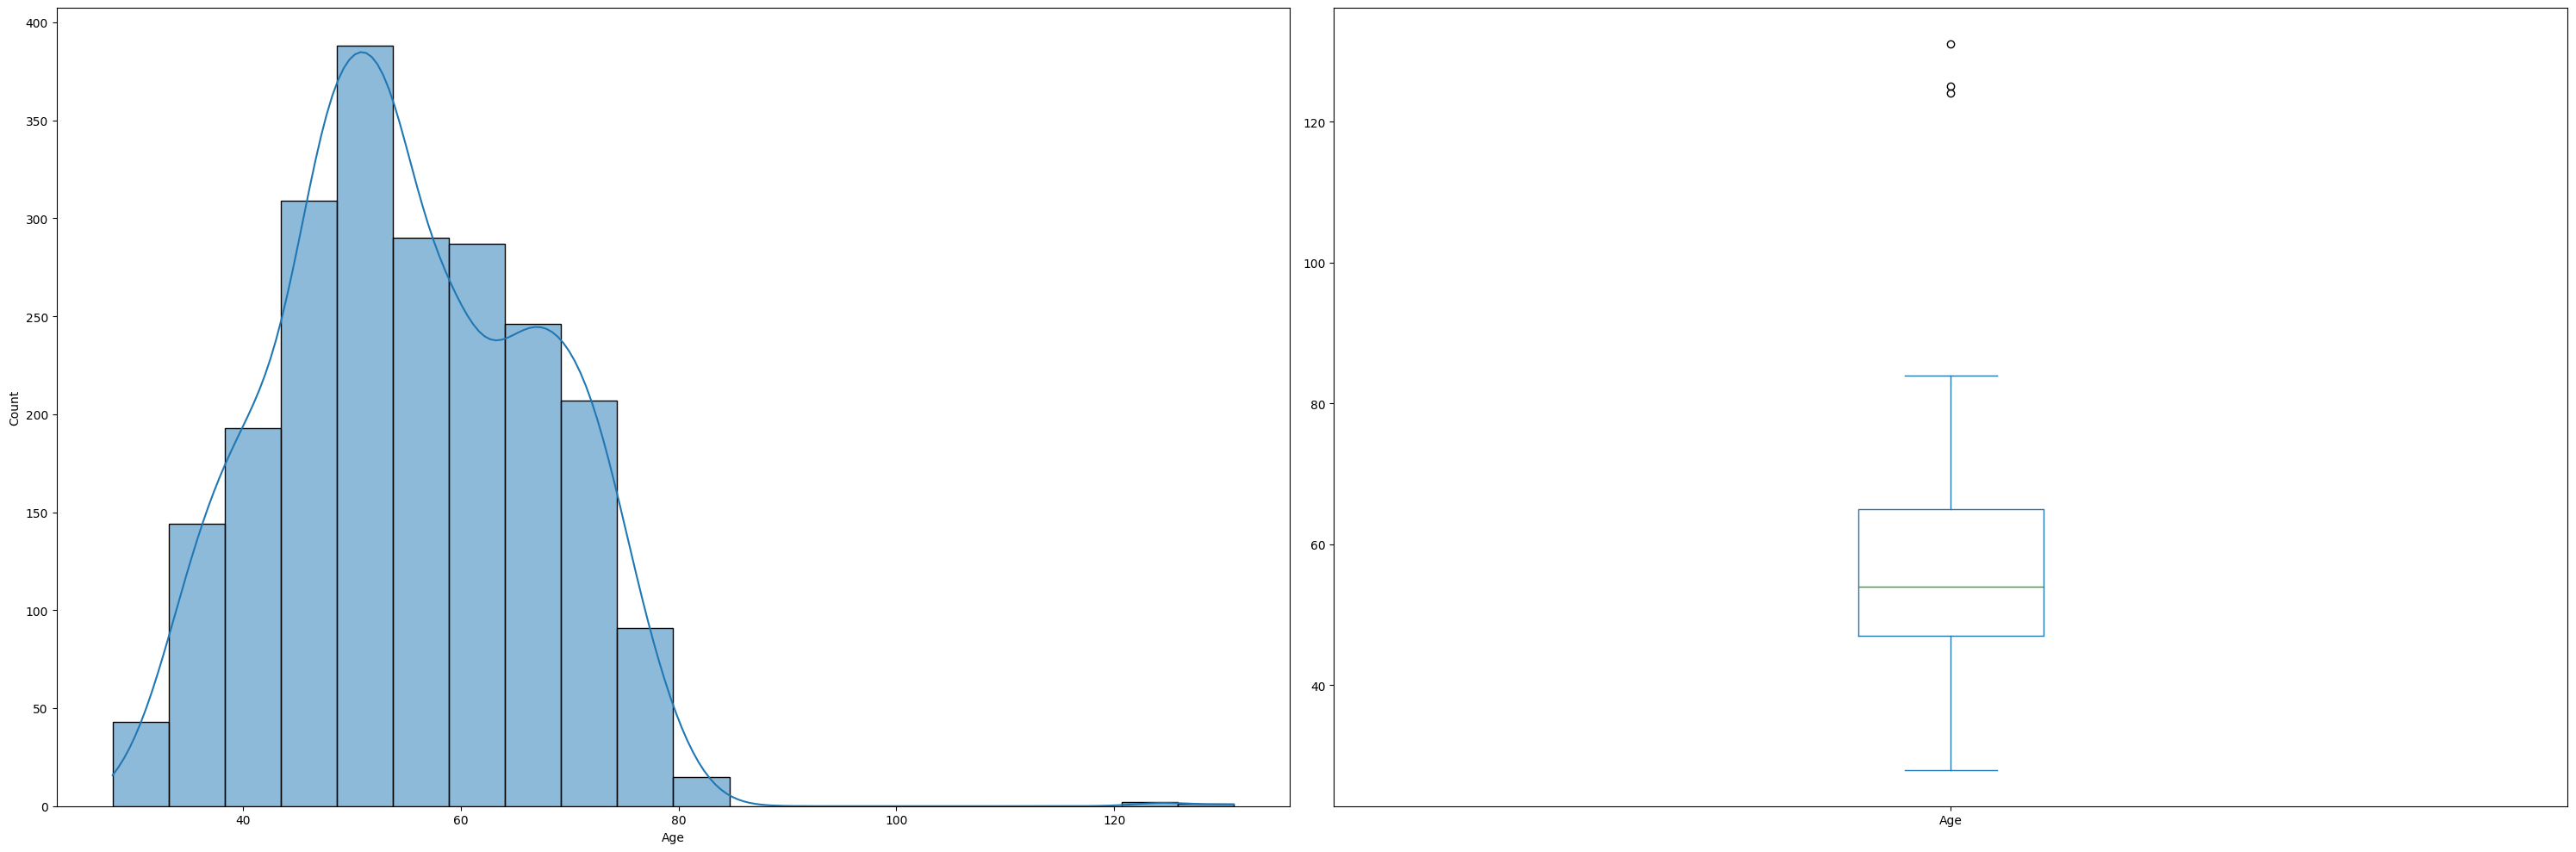

In [12]:
plt.figure(figsize=(30, 10))
plt.subplot(1, 2, 1)
sns.histplot(df['Age'],kde=True,bins=20)
plt.subplot(1, 2, 2)
df['Age'].plot(kind='box');
plt.tight_layout()


In [13]:
df['Age'].describe()

count    2216.000000
mean       55.179603
std        11.985554
min        28.000000
25%        47.000000
50%        54.000000
75%        65.000000
max       131.000000
Name: Age, dtype: float64

**Income**

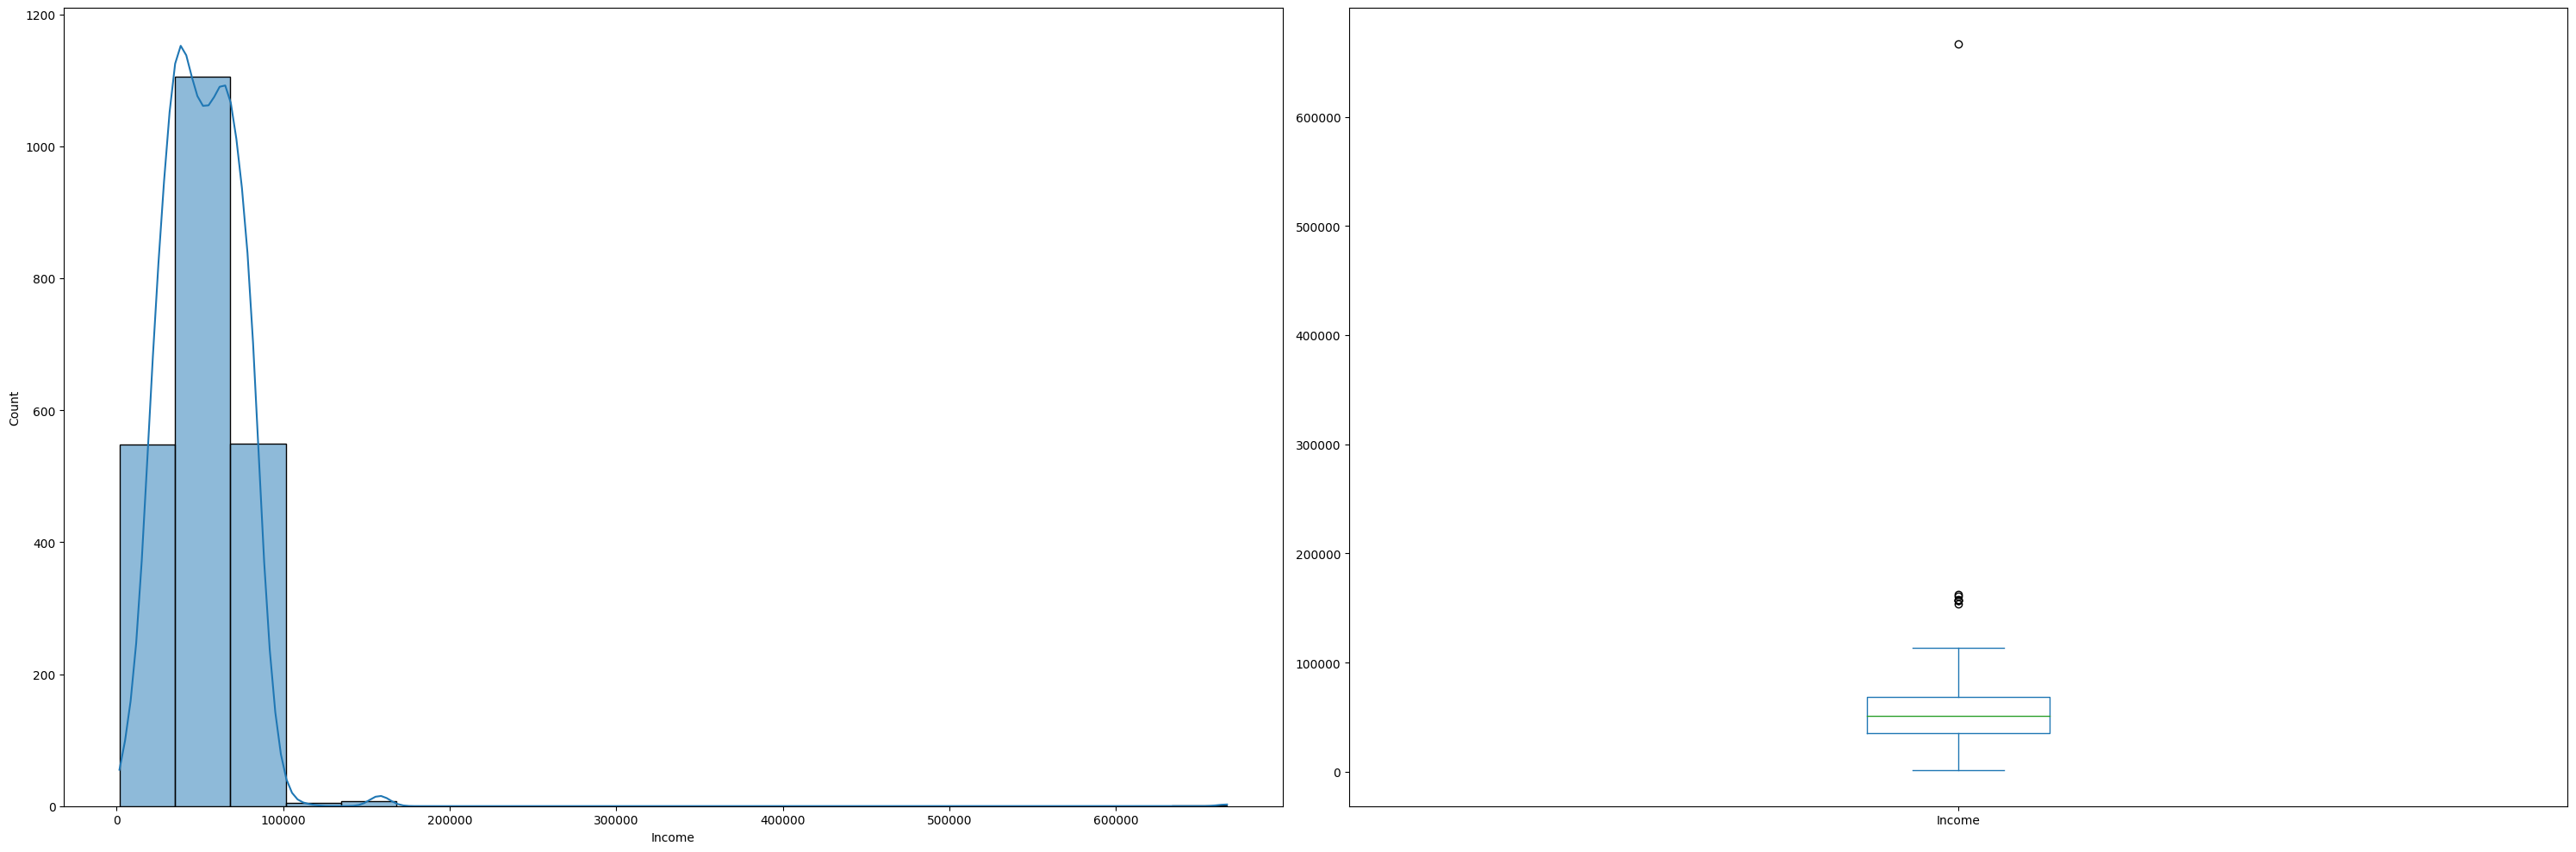

In [14]:
plt.figure(figsize=(30, 10))
plt.subplot(1, 2, 1)
sns.histplot(df['Income'],kde=True,bins=20)
plt.subplot(1, 2, 2)
df['Income'].plot(kind='box');
plt.tight_layout()


**Duration as a Customer**

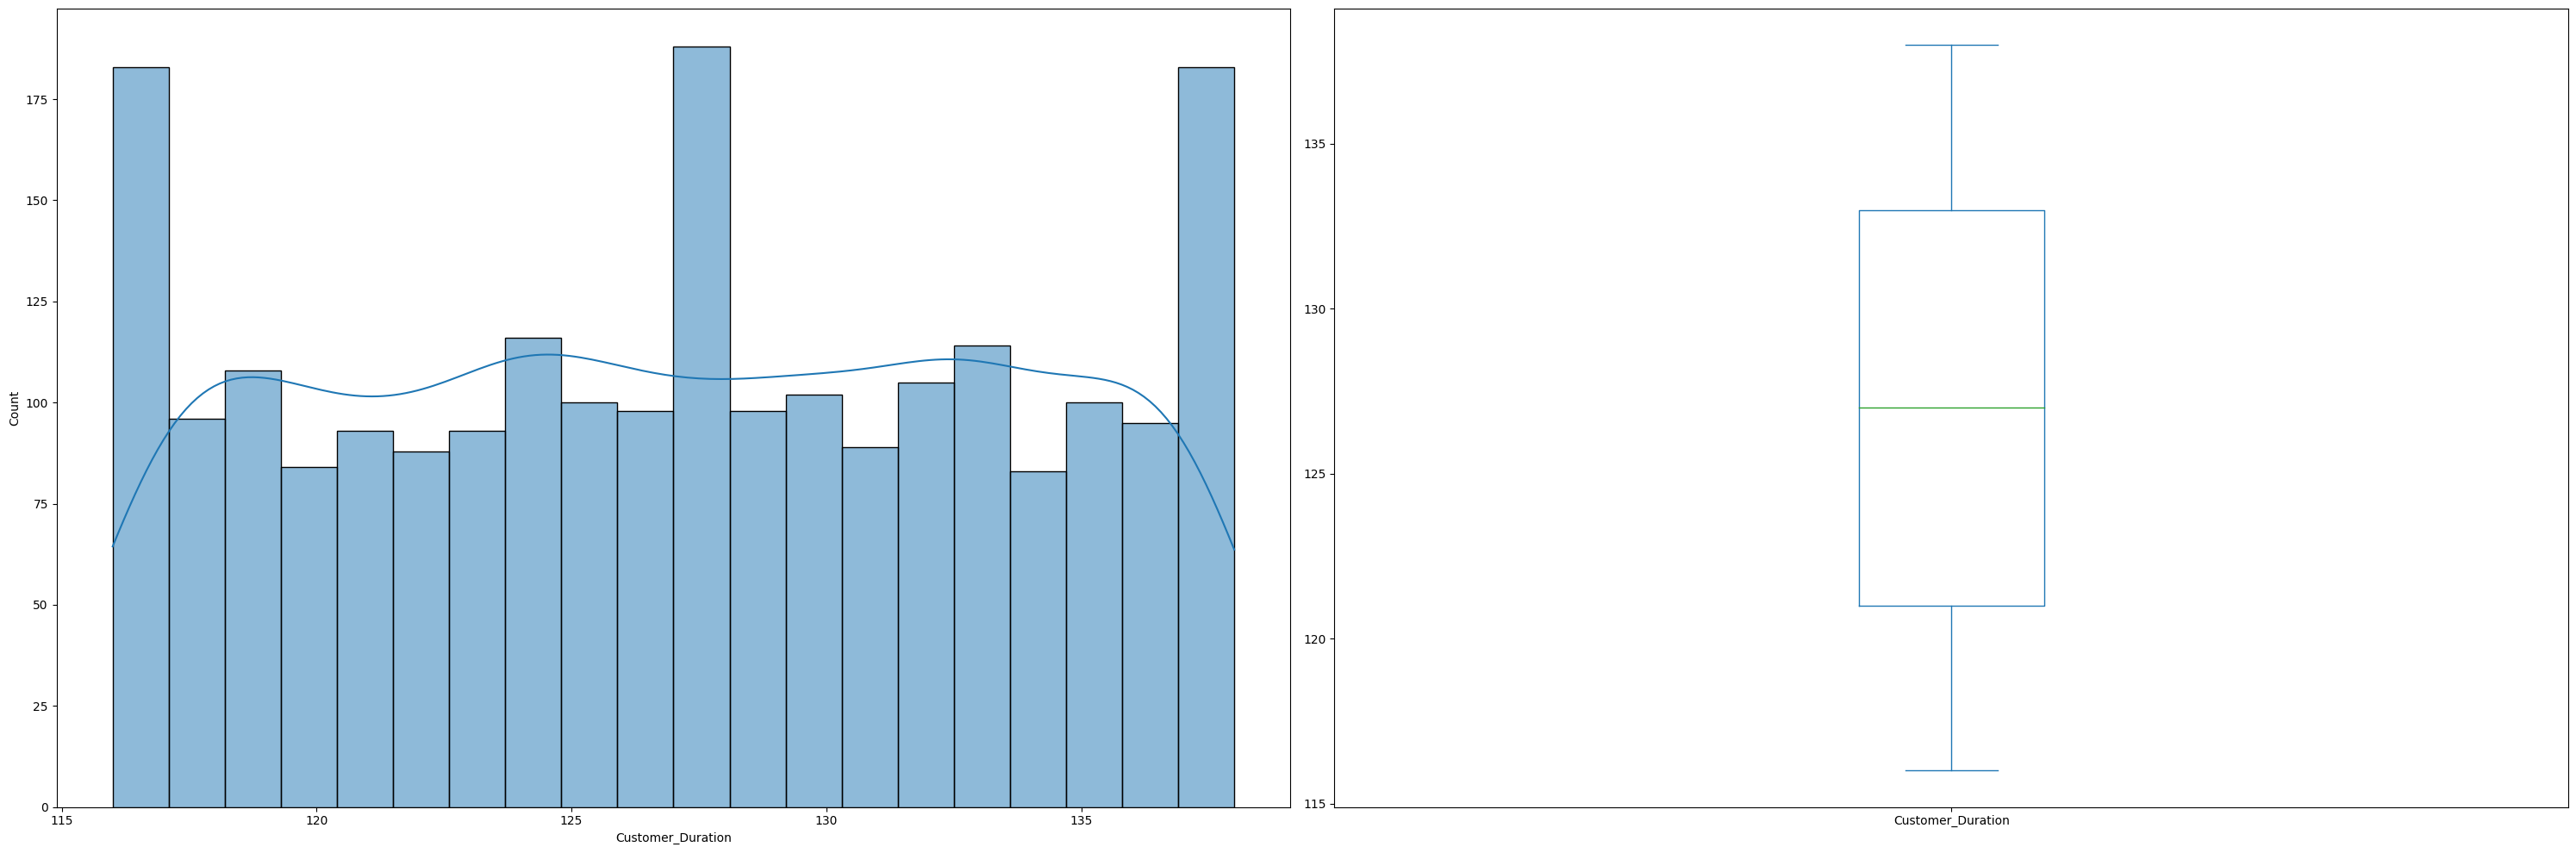

In [15]:
plt.figure(figsize=(30, 10))
plt.subplot(1, 2, 1)
sns.histplot(df['Customer_Duration'],kde=True,bins=20)
plt.subplot(1, 2, 2)
df['Customer_Duration'].plot(kind='box');
plt.tight_layout()


**Recency**

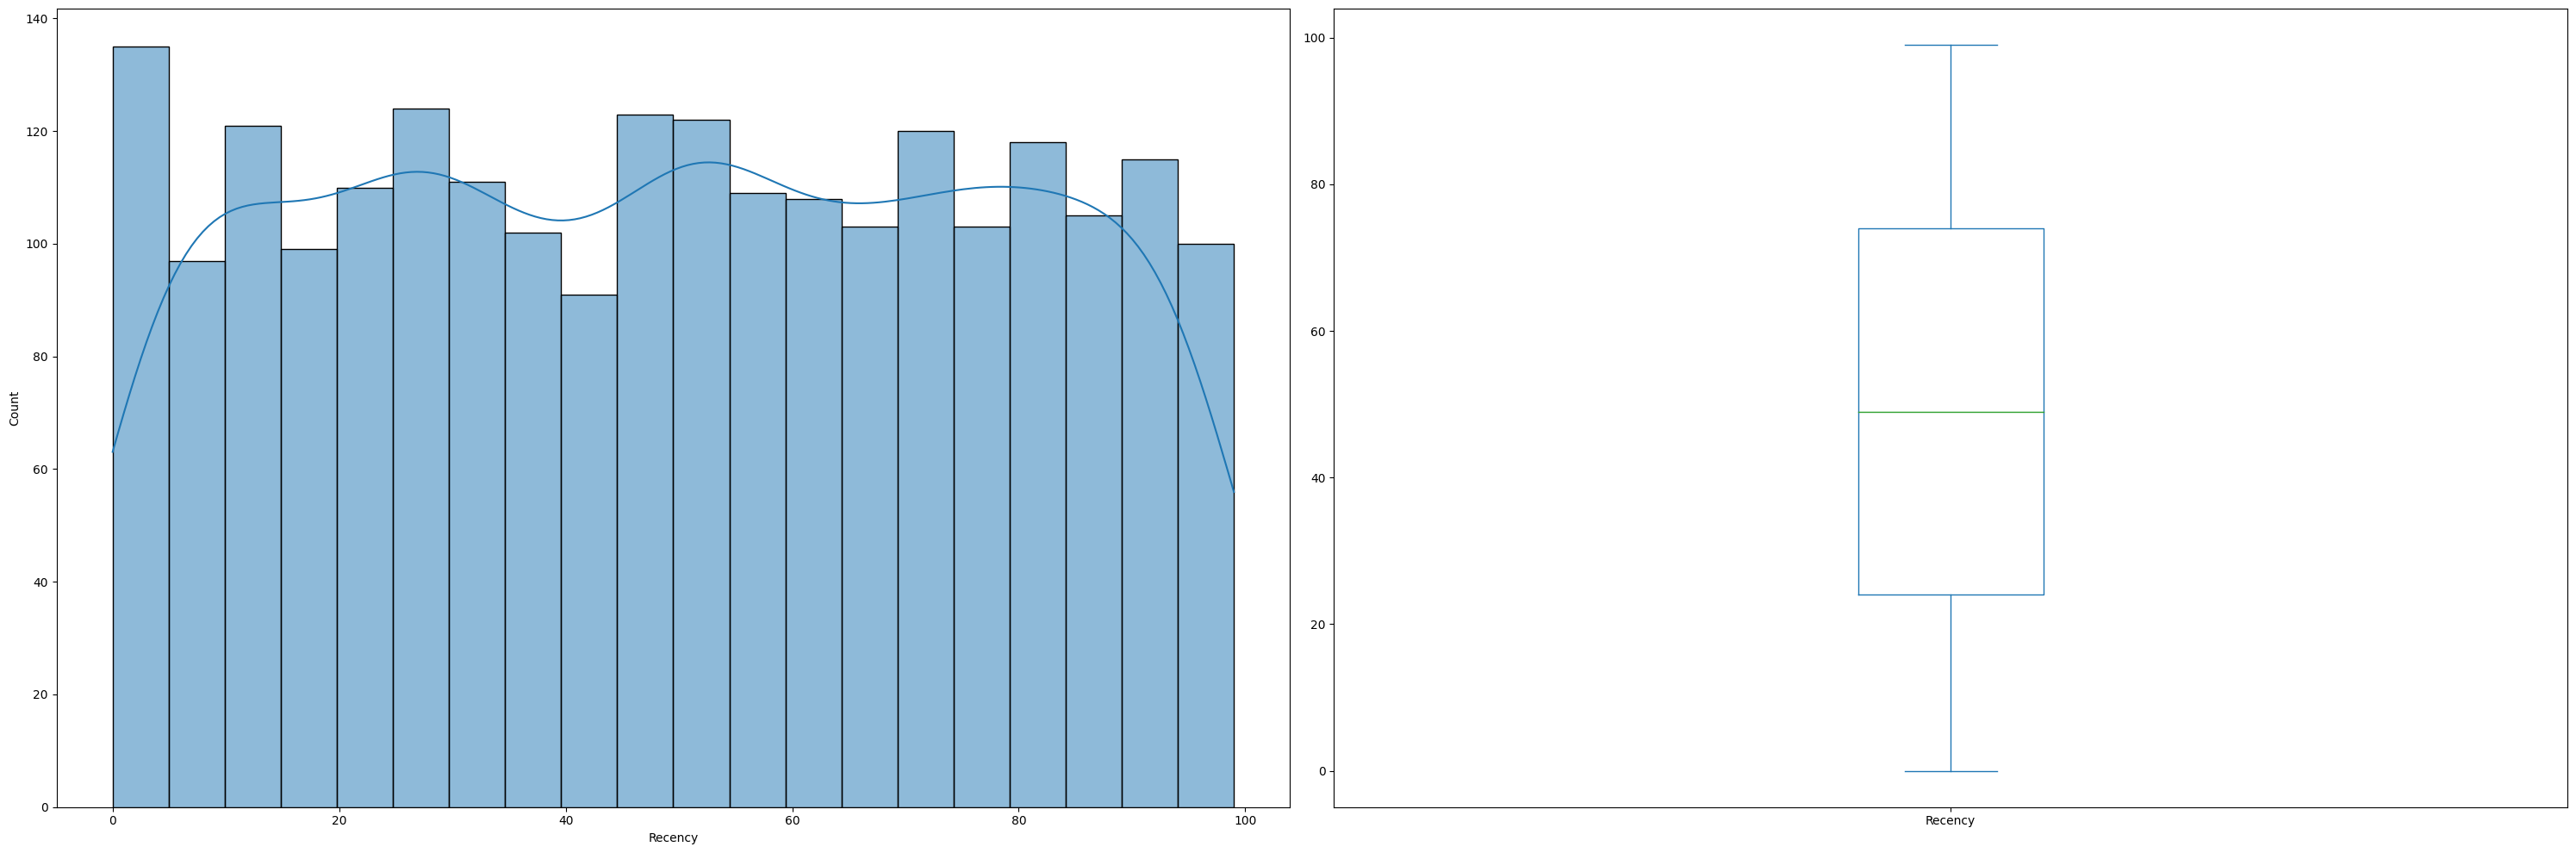

In [16]:
plt.figure(figsize=(30, 10))
plt.subplot(1, 2, 1)
sns.histplot(df['Recency'],kde=True,bins=20)
plt.subplot(1, 2, 2)
df['Recency'].plot(kind='box');
plt.tight_layout()


Remove outliers

In [17]:
df = df.loc[df['Age'] < 85]
df.shape

(2213, 28)

In [20]:
# Replace values over 100000 income with median

df.loc[df['Income'] > 100000, 'Income'] = df['Income'].median()
df['Income'].describe()

count     2213.000000
mean     51499.566652
std      20516.579272
min       1730.000000
25%      35246.000000
50%      51373.000000
75%      68117.000000
max      98777.000000
Name: Income, dtype: float64

In [ ]:
pd.crosstab(df['Marital_Status'], df['Response'])